In [1]:
# WHICH METRIC IS MOST IMPORTANT FOR THIS TASK
# In this case, it is important to identify all the people that, based on their features, are likely to subscribe a bank deposit.
# Once they are identified, they can be contacted by the marketing agents, and the probability they will say "yes" will be high.
# For this reason, it is important they are identified by the model --> we want high recall.
# If the model fails and says a customer is a "yes" while in reality they are a "no", it will be a waste of time by the bank.
# However, if their number is reasonably low, the bank would probably be happier to hear a "no" than to miss a potential new subscriber.
# This means that we want high recall, while the precision is not so important (it is, because we don't want to phone to all the 
# customers, but calling some "no" customers is a waste of time the bank would bear, I suppose).

In [2]:
import pandas as pd
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
from collections import Counter
import numpy as np
import imblearn
import random
import matplotlib.pyplot as plt

from utils.resampling import *
from utils.metrics import compute_metrics, specificity_score

In [3]:
df = pd.read_csv('data/ohe_df.csv')
df.shape

(45210, 35)

# <ins> SCALING

In [4]:
features_to_scale = [feat for feat in df.columns if len(df[feat].value_counts()) > 2]
features_to_scale

['age', 'balance', 'previous']

In [5]:
# Instantiate scaler
scaler = sklearn.preprocessing.StandardScaler()

In [6]:
# Fit scaler on just the continuous features (do not scale one-hot features!) and transform
scaler.fit(df[features_to_scale])
scaled_array = scaler.transform(df[features_to_scale])
df[features_to_scale] = scaled_array

# <ins> SPLIT

In [7]:
X = df.drop(columns='y')
y = df['y']

In [8]:
# # Standard split in train, val and test.
# train_perc = 0.70
# val_perc = 0.20
# test_perc = 0.10

# X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(
#     X,
#     y,
#     test_size=test_perc,
#     stratify=y,
#     random_state=42
# )

# print(X_train_val.shape, X_test.shape)

# X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
#     X_train_val,
#     y_train_val,
#     test_size=val_perc/(1-test_perc),
#     stratify=y_train_val,
#     random_state=42
# )

# print(X_train.shape, X_val.shape)

# do_numbers_add_up = X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == df.shape[0]

# print(do_numbers_add_up)

# # (40689, 34) (4521, 34)
# # (31647, 34) (9042, 34)
# # True

In [9]:
# Split for cross-validation
train_perc = 0.80
test_perc = 0.20

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    test_size=test_perc,
    stratify=y,
    random_state=42
)

print(X_train.shape, X_test.shape)

(36168, 34) (9042, 34)


# <ins> RESAMPLING

In [10]:
### Key points:
# (1) To be done after the splitting, because downsampling (or upsampling) change the distribution of 
# 0s and 1s in the training set, but they should not change the distribution in the validation or 
# test set because these should reflect the real world distribution.

# (2) For the same reason, don't do resampling on a dataset that will be used for cross-validation,
# because the folds used as validation would result with a distribution different from the real.
# Make the cross-validation process add resampling internally (see below).

In [11]:
# ## DOWNSAMPLING
# # Downsample the majority class
# X_train, y_train = downsampling(X=X_train, y=y_train, factor=2)

# X_train.shape, y_train.shape

In [12]:
# # # UPSAMPLING
# # Upsample the minority class
# # actually, here I'll upsample the minority class (adding duplicates) and 
# # downsample the majority class to make a balanced dataset
# X_train, y_train = upsampling(X=X_train, y=y_train, factor=1) # `factor=2` --> class 1 becomes 3x

# X_train.shape, y_train.shape

In [13]:
# ## SMOTE (Synthetic Minority Over-sampling TEchnique)
# # - SMOTE will balance the dataset by creating synthetic data with class 1 via KNN.
# # - To avoid a too high proportion of synthetic data, class 0 is first downsampled
# #   to N, where N is the number of samples per class I'll want in the final dataset.
# # - This is here expressed as a multiple of the number of instances of class 1 in 
# #   the original dataset.
# X_train, y_train = smote_sampling(X=X_train, y=y_train, factor=2)

# X_train.shape, y_train.shape

# <ins> RANDOM FOREST

## SIMPLE APPROACH

In [14]:
# Fit model on training set and test it on the test set (just to show the basic approach, while in
# a proper analysis we should use the validation set for the hyperparamer tuning)

In [15]:
rf_model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None, # None = max depth possible
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    n_jobs=12,
    random_state=42,
    class_weight=None # 'balanced_subsample' for unbalanced data
)

# Effect of using class weights for unbalanced data:
# - in boostrapping the instances for each tree, to ensure adeguate representation of the rare class 
#   (specific for `balanced_subsample`).
# - changes Gini index and therefore features to split upon.

In [16]:
_ = rf_model.fit(X=X_train, y=y_train)
y_pred = rf_model.predict(X_test)

In [17]:
metrics = compute_metrics(preds=y_pred, trues=y_test)
metrics

AttrDict({'tp': 524, 'tn': 6505, 'fp': 1479, 'fn': 534, 'accuracy': 0.78, 'precision': 0.26, 'recall': 0.5, 'specificity': 0.81})

In [18]:
# Confusion matrix
sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[6505, 1479],
       [ 534,  524]])

In [19]:
# AUC
probs = rf_model.predict_proba(X_test)[:, 1]
auc = sklearn.metrics.roc_auc_score(y_test, probs)
auc = round(auc, 2)

print(f'AUC: {auc}')

AUC: 0.7


In [20]:
# Create df for easier (manual) logging
metrics_df = pd.DataFrame({
    'accuracy': metrics.accuracy,
    'precision': metrics.precision,
    'recall': metrics.recall,
    'specificity': metrics.specificity,
    'auc': auc
}, index=[0])

metrics_df.to_csv('metrics.csv', index=False)

metrics_df

,accuracy,precision,recall,specificity,auc
0,0.78,0.26,0.5,0.81,0.7


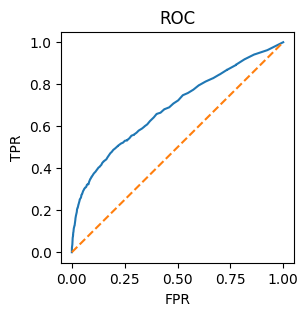

In [20]:
# ROC
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, probs)

plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [21]:
# Results are pretty bad for class 1 because the dataset is unbalanced.

## FEATURE IMPORTANCE

In [22]:
feature_importances = rf_model.feature_importances_.round(3)

type(feature_importances), feature_importances.shape

(numpy.ndarray, (34,))

In [23]:
feat_imp_dict = dict(zip(feature_importances, X_train.columns))
sorted(feat_imp_dict.items(), key=lambda x:x[0], reverse=True)[:20]

[(0.394, 'balance'),
 (0.19, 'age'),
 (0.094, 'poutcome_success'),
 (0.033, 'previous'),
 (0.018, 'loan'),
 (0.017, 'n_contacts_1'),
 (0.016, 'n_contacts_2-8'),
 (0.015, 'job_blue-collar'),
 (0.014, 'education_tertiary'),
 (0.011, 'marital_single'),
 (0.01, 'marital_divorced'),
 (0.007, 'job_unemployed'),
 (0.006, 'pdays_1-200'),
 (0.005, 'pdays_400+'),
 (0.004, 'poutcome_unknown'),
 (0.003, 'default')]

## CROSS-VALIDATION

In [24]:
# # Basic approach to cross-validation

# rf_model = sklearn.ensemble.RandomForestClassifier(
#     n_estimators=200,
#     criterion='gini',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     max_features=None,
#     bootstrap=True,
#     n_jobs=12,
#     random_state=42,
#     class_weight=None
# )

# cv_scores = sklearn.model_selection.cross_val_score(
#     estimator=rf_model, 
#     X=X_train, 
#     y=y_train,
#     scoring='recall',
#     cv=5, # number of folds
#     n_jobs=12
# )

# cv_scores.mean().round(2)

# # since `cv=int`, and estimator is a classifier and y is binary --> StratifiedKFold is used (see docs)

# # For the original, unbalanced dataset: 0.21
# # For a resempled dataset: 0.97

# # Problem: in this case, the training set has undergone resampling. Therefore during cross-validation, 
# # each fold used as validation has undergone resampling too, so it doesn't reflect the real data 
# # # distribution, and so do the performances obtained.

In [14]:
# # Cross-validation for unbalanced data: must use non-resampled dataset!
#
# Use a Pipeline for each set of folds. This pipeline will do resampling separately for each iteration,
# and only for the folds used for the training.
# The pipeline here is composed of a downsampler, an upsampler, and a model.

# Downsampler
# sampling_strategy=0.5 --> class 1 will become 50% of class 0 (resize class 0 so that it becomes
# double class 1)
downsampler = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.25, random_state=42)
# 0.25 --> class 1 is 25% of class 0 --> class 0 is 4x class 1
# 0.5 --> class 1 is 50% of class 0 --> class 0 is 2x class 1
# 0.75 --> class 1 is 75% of class 0 --> class 0 is 1.33x class 1
# 1.0 --> class 1 is 100% of class 0 --> class 0 is 1x class 1

# Upsampler
# sampling_strategy=1.0 --> ratio between class 1 and class 0 will be 1 --> balanced
upsampler = imblearn.over_sampling.RandomOverSampler(sampling_strategy=1.0, random_state=42)

# Model
rf_model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    n_jobs=12,
    random_state=42,
    class_weight=None
)

pipeline = imblearn.pipeline.Pipeline([
    ('downsampler', downsampler),
    ('upsampler', upsampler),
    ('model', rf_model) 
])

In [26]:
# Just one metric
results = sklearn.model_selection.cross_val_score(
    pipeline, 
    X_train, 
    y_train, 
    cv=10, 
    scoring='recall'
)

print(results.mean().round(2))

# 5 fold --> 0.49
# 10 fold --> 0.49

0.49


In [20]:
# For more metrics
scoring_metrics = {'accuracy': 'accuracy', 
                   'precision': 'precision', 
                   'recall': 'recall', 
                   'f1': 'f1',
                   'specificity': sklearn.metrics.make_scorer(specificity_score),
                   'auc': 'roc_auc',
}

result = sklearn.model_selection.cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=10,
    scoring=scoring_metrics,
    n_jobs=12
)

# for metric in result:
#     print(f'{metric}: {result[metric].mean().round(2)}')

In [21]:
metrics_df = pd.DataFrame({
    'accuracy': result['test_accuracy'].mean().round(2),
    'precision': result['test_precision'].mean().round(2),
    'recall': result['test_recall'].mean().round(2),
    'specificity': result['test_specificity'].mean().round(2),
    'auc': result['test_auc'].mean().round(2)
}, index=[0])

metrics_df.to_csv('metrics.csv', index=False)

metrics_df

,accuracy,precision,recall,specificity,auc
0,0.83,0.31,0.38,0.91,0.69


## HYPERPARAMETER SEARCH

In [54]:
## BASIC APPROACH: fine-tune just the model's parameters

# Parameters distribution from which RandomizedSearchCV will randomly pick parameters to
# create its 'n_iter' different sets of parameters.
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Init blank (default) model
rf = sklearn.ensemble.RandomForestClassifier()

random_search = sklearn.model_selection.RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_distributions, 
    n_iter=10, # number of different sets of parameters, the higher the better
    cv=5, # number of folds
    scoring='recall',
    verbose=1, 
    random_state=42, 
    n_jobs=12
)

# Fit the model
_ = random_search.fit(X_train, y_train)

print("Best score:", random_search.best_score_.round(2))
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score: 0.21
Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': True}


In [ ]:
## PRO APPROACH: fine-tune also parameters in the pipeline

param_distributions = {
    'downsampler__sampling_strategy': [0.25, 0.5, 0.75, 1.0],
    'upsampler__sampling_strategy': [0.75, 1.0, 1.25],
    'model__n_estimators': [50, 100, 200, 300, 500],
    'model__max_depth': [None, 10, 20, 30, 40, 50],
}

random_search = sklearn.model_selection.RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=50, 
    cv=10, 
    scoring='recall', # if 'scoring_metrics' was passed, the first metric would be used 
    n_jobs=12, 
    random_state=42, 
    verbose=1,
    refit=False # `True` to refit the model on the best parar set
)

random_search.fit(X_train, y_train)

In [18]:
print("Best score:", random_search.best_score_.round(2))
print("Best parameters:", random_search.best_params_)

Best score: 0.56
Best parameters: {'upsampler__sampling_strategy': 1.0, 'model__n_estimators': 200, 'model__max_depth': 30, 'downsampler__sampling_strategy': 0.75}


In [ ]:
# TODO: redo it for 100 iters